# Exercise 4

## Import packages

In [38]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [39]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    if use_cuda:
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    model.train()
    
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i%log_interval == 0:
            print(f"Epoch {epoch}, log interval no.:{i//log_interval}, Loss={loss.item():.4f}")

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [40]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [41]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10)   

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run network layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [42]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()

        self.fc1 = nn.Linear(784,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10) 

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        output = F.log_softmax(x, dim=1)
        
        return output

In [43]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()

        self.fc1 = nn.Linear(784,200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.bn2 = nn.BatchNorm1d(60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10) 

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        output = F.log_softmax(x, dim=1)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [ ]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1,32,3,1,0)
        self.conv2 = nn.Conv2d(32,64,3,2,0)
        self.fc1 = nn.Linear(64*12*12,128)
        self.fc2 = nn.Linear(128,10)

    def forward(self, x):
        # TODO: run convolutional layers
        print(x.shape)
        x = self.conv1(x)
        print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        print(x.shape)
        x = F.relu(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1,64*12*12)
        print(x.shape)
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        print(x.shape)
        x = F.relu(x)
        x = self.fc2(x)
        print(x.shape)

        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [ ]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

    def forward(self, x):
        pass

In [ ]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

    def forward(self, x):
        pass

Epoch 1, log interval no.:0, Loss=2.3691
Epoch 1, log interval no.:1, Loss=2.3181
Epoch 1, log interval no.:2, Loss=2.3294
Epoch 1, log interval no.:3, Loss=2.3038
Epoch 1, log interval no.:4, Loss=2.2974
Epoch 1, log interval no.:5, Loss=2.2915
Epoch 1, log interval no.:6, Loss=2.0553
Epoch 1, log interval no.:7, Loss=1.8391
Epoch 1, log interval no.:8, Loss=1.6185
Epoch 1, log interval no.:9, Loss=1.4673

Test set: Average loss: 1.4268, Accuracy: 4773/10000 (47.73%)



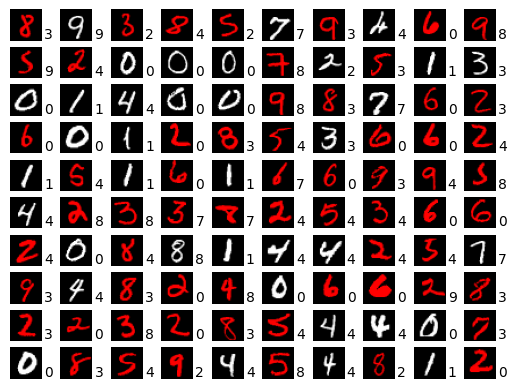

Epoch 2, log interval no.:0, Loss=1.4117
Epoch 2, log interval no.:1, Loss=1.4583
Epoch 2, log interval no.:2, Loss=1.2427
Epoch 2, log interval no.:3, Loss=1.0523
Epoch 2, log interval no.:4, Loss=1.2720
Epoch 2, log interval no.:5, Loss=1.0757
Epoch 2, log interval no.:6, Loss=0.8989
Epoch 2, log interval no.:7, Loss=0.7176
Epoch 2, log interval no.:8, Loss=0.9222
Epoch 2, log interval no.:9, Loss=0.6648

Test set: Average loss: 0.6487, Accuracy: 7809/10000 (78.09%)



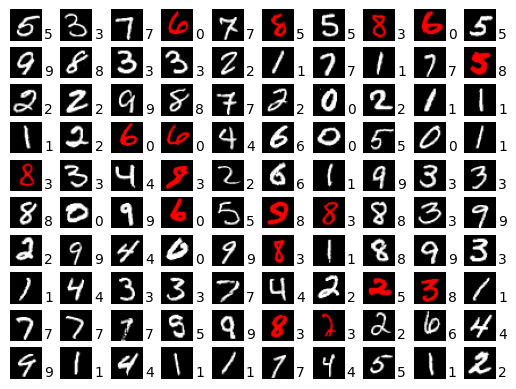

Epoch 3, log interval no.:0, Loss=0.8158
Epoch 3, log interval no.:1, Loss=0.5893
Epoch 3, log interval no.:2, Loss=0.7531
Epoch 3, log interval no.:3, Loss=0.7000
Epoch 3, log interval no.:4, Loss=0.5169
Epoch 3, log interval no.:5, Loss=0.3961
Epoch 3, log interval no.:6, Loss=0.4946
Epoch 3, log interval no.:7, Loss=0.3766
Epoch 3, log interval no.:8, Loss=0.6412
Epoch 3, log interval no.:9, Loss=0.2745

Test set: Average loss: 0.3624, Accuracy: 9168/10000 (91.68%)



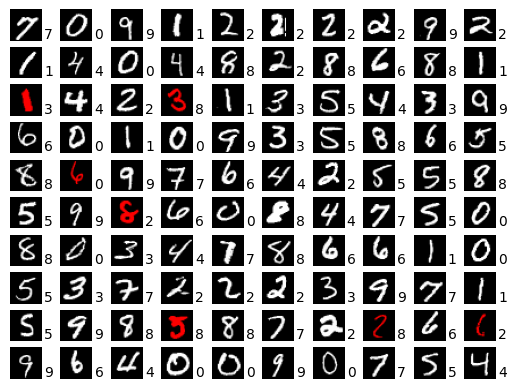

Epoch 4, log interval no.:0, Loss=0.1724
Epoch 4, log interval no.:1, Loss=0.3216
Epoch 4, log interval no.:2, Loss=0.3665
Epoch 4, log interval no.:3, Loss=0.2400
Epoch 4, log interval no.:4, Loss=0.4222
Epoch 4, log interval no.:5, Loss=0.3978
Epoch 4, log interval no.:6, Loss=0.3718
Epoch 4, log interval no.:7, Loss=0.1399
Epoch 4, log interval no.:8, Loss=0.2337
Epoch 4, log interval no.:9, Loss=0.4298

Test set: Average loss: 0.2797, Accuracy: 9327/10000 (93.27%)



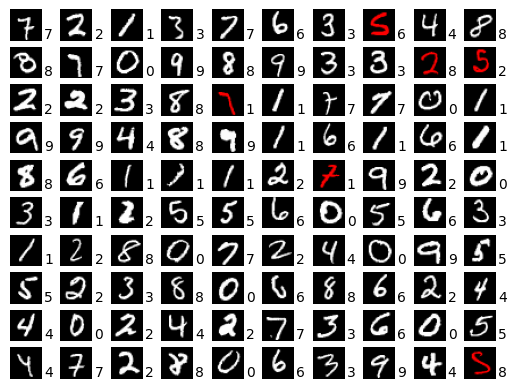

Epoch 5, log interval no.:0, Loss=0.1246
Epoch 5, log interval no.:1, Loss=0.2230
Epoch 5, log interval no.:2, Loss=0.2682
Epoch 5, log interval no.:3, Loss=0.2037
Epoch 5, log interval no.:4, Loss=0.1880
Epoch 5, log interval no.:5, Loss=0.1194
Epoch 5, log interval no.:6, Loss=0.1251
Epoch 5, log interval no.:7, Loss=0.3858
Epoch 5, log interval no.:8, Loss=0.1328
Epoch 5, log interval no.:9, Loss=0.1715

Test set: Average loss: 0.2555, Accuracy: 9367/10000 (93.67%)



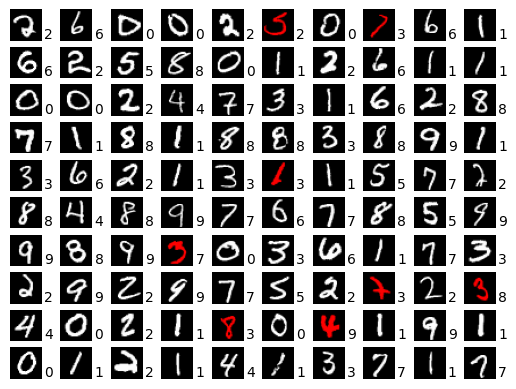

Epoch 6, log interval no.:0, Loss=0.2723
Epoch 6, log interval no.:1, Loss=0.4297
Epoch 6, log interval no.:2, Loss=0.1719
Epoch 6, log interval no.:3, Loss=0.1079
Epoch 6, log interval no.:4, Loss=0.1347
Epoch 6, log interval no.:5, Loss=0.2948
Epoch 6, log interval no.:6, Loss=0.1799
Epoch 6, log interval no.:7, Loss=0.1995
Epoch 6, log interval no.:8, Loss=0.2371
Epoch 6, log interval no.:9, Loss=0.0726

Test set: Average loss: 0.2269, Accuracy: 9444/10000 (94.44%)



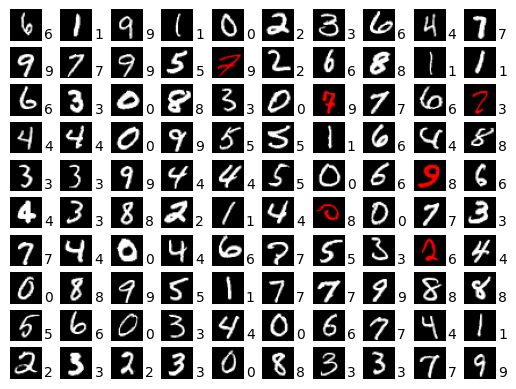

Epoch 7, log interval no.:0, Loss=0.2839
Epoch 7, log interval no.:1, Loss=0.1317
Epoch 7, log interval no.:2, Loss=0.1146
Epoch 7, log interval no.:3, Loss=0.1068
Epoch 7, log interval no.:4, Loss=0.2193
Epoch 7, log interval no.:5, Loss=0.1680
Epoch 7, log interval no.:6, Loss=0.0934
Epoch 7, log interval no.:7, Loss=0.0978
Epoch 7, log interval no.:8, Loss=0.3243
Epoch 7, log interval no.:9, Loss=0.0342

Test set: Average loss: 0.2164, Accuracy: 9455/10000 (94.55%)



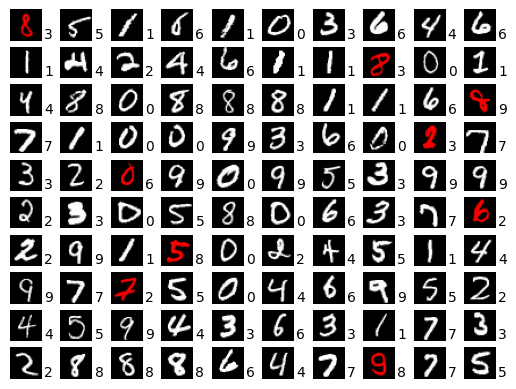

Epoch 8, log interval no.:0, Loss=0.1736
Epoch 8, log interval no.:1, Loss=0.1085
Epoch 8, log interval no.:2, Loss=0.0627
Epoch 8, log interval no.:3, Loss=0.0454
Epoch 8, log interval no.:4, Loss=0.1272
Epoch 8, log interval no.:5, Loss=0.0810
Epoch 8, log interval no.:6, Loss=0.0803
Epoch 8, log interval no.:7, Loss=0.0985
Epoch 8, log interval no.:8, Loss=0.0802
Epoch 8, log interval no.:9, Loss=0.1995

Test set: Average loss: 0.2093, Accuracy: 9480/10000 (94.80%)



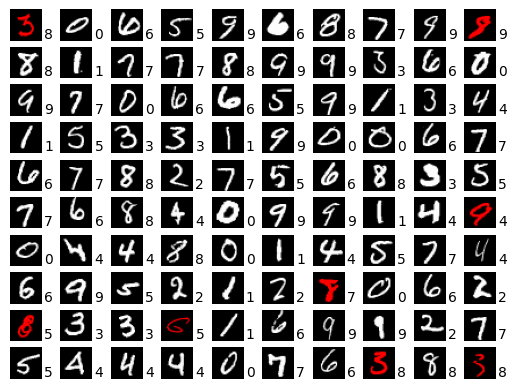

Epoch 9, log interval no.:0, Loss=0.0522
Epoch 9, log interval no.:1, Loss=0.0743
Epoch 9, log interval no.:2, Loss=0.2978
Epoch 9, log interval no.:3, Loss=0.0631
Epoch 9, log interval no.:4, Loss=0.1107
Epoch 9, log interval no.:5, Loss=0.2469
Epoch 9, log interval no.:6, Loss=0.0874
Epoch 9, log interval no.:7, Loss=0.1484
Epoch 9, log interval no.:8, Loss=0.1406
Epoch 9, log interval no.:9, Loss=0.0789

Test set: Average loss: 0.2115, Accuracy: 9465/10000 (94.65%)



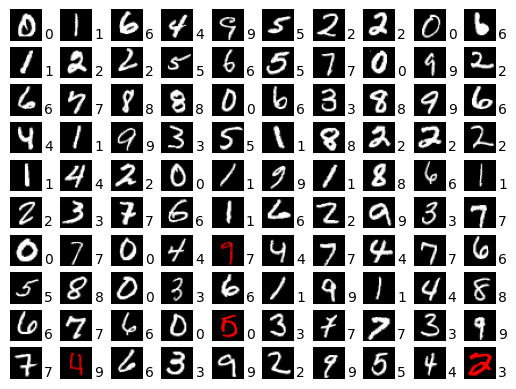

Epoch 10, log interval no.:0, Loss=0.5641
Epoch 10, log interval no.:1, Loss=0.0481
Epoch 10, log interval no.:2, Loss=0.1129
Epoch 10, log interval no.:3, Loss=0.1656
Epoch 10, log interval no.:4, Loss=0.1078
Epoch 10, log interval no.:5, Loss=0.4791
Epoch 10, log interval no.:6, Loss=0.1133
Epoch 10, log interval no.:7, Loss=0.3176
Epoch 10, log interval no.:8, Loss=0.0328
Epoch 10, log interval no.:9, Loss=0.0624

Test set: Average loss: 0.2017, Accuracy: 9502/10000 (95.02%)



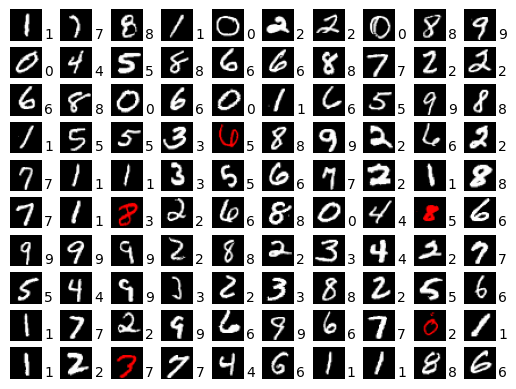

In [44]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpointFCNet1.pt")

Epoch 1, log interval no.:0, Loss=2.3275
Epoch 1, log interval no.:1, Loss=0.4093
Epoch 1, log interval no.:2, Loss=0.3524
Epoch 1, log interval no.:3, Loss=0.0986
Epoch 1, log interval no.:4, Loss=0.2964
Epoch 1, log interval no.:5, Loss=0.1824
Epoch 1, log interval no.:6, Loss=0.0651
Epoch 1, log interval no.:7, Loss=0.0909
Epoch 1, log interval no.:8, Loss=0.1268
Epoch 1, log interval no.:9, Loss=0.3013

Test set: Average loss: 0.1578, Accuracy: 9539/10000 (95.39%)



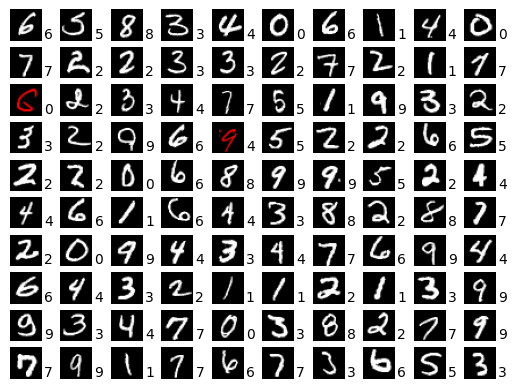

Epoch 2, log interval no.:0, Loss=0.3637
Epoch 2, log interval no.:1, Loss=0.0189
Epoch 2, log interval no.:2, Loss=0.0742
Epoch 2, log interval no.:3, Loss=0.0389
Epoch 2, log interval no.:4, Loss=0.2334
Epoch 2, log interval no.:5, Loss=0.1263
Epoch 2, log interval no.:6, Loss=0.2357
Epoch 2, log interval no.:7, Loss=0.0165
Epoch 2, log interval no.:8, Loss=0.1088
Epoch 2, log interval no.:9, Loss=0.0764

Test set: Average loss: 0.0792, Accuracy: 9765/10000 (97.65%)



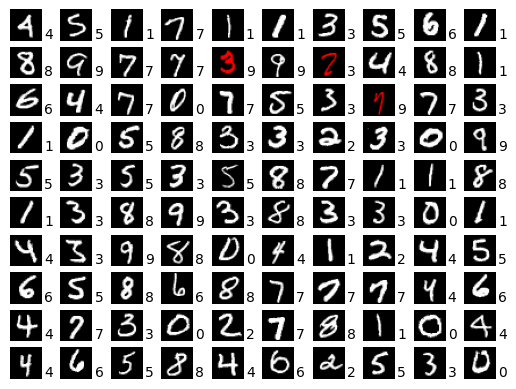

Epoch 3, log interval no.:0, Loss=0.0265
Epoch 3, log interval no.:1, Loss=0.0022
Epoch 3, log interval no.:2, Loss=0.0255
Epoch 3, log interval no.:3, Loss=0.0105
Epoch 3, log interval no.:4, Loss=0.0932
Epoch 3, log interval no.:5, Loss=0.0030
Epoch 3, log interval no.:6, Loss=0.0972
Epoch 3, log interval no.:7, Loss=0.1088
Epoch 3, log interval no.:8, Loss=0.0139
Epoch 3, log interval no.:9, Loss=0.0150

Test set: Average loss: 0.0834, Accuracy: 9768/10000 (97.68%)



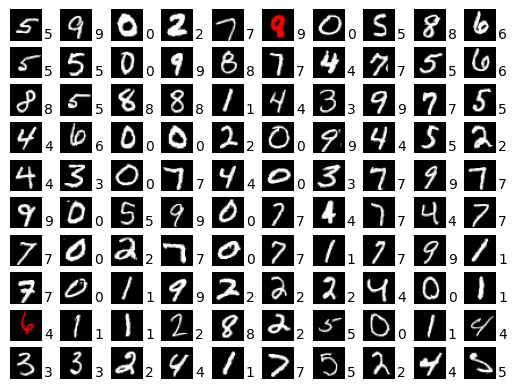

Epoch 4, log interval no.:0, Loss=0.0059
Epoch 4, log interval no.:1, Loss=0.0046
Epoch 4, log interval no.:2, Loss=0.0160
Epoch 4, log interval no.:3, Loss=0.0024
Epoch 4, log interval no.:4, Loss=0.0059
Epoch 4, log interval no.:5, Loss=0.0270
Epoch 4, log interval no.:6, Loss=0.0091
Epoch 4, log interval no.:7, Loss=0.0009
Epoch 4, log interval no.:8, Loss=0.0504
Epoch 4, log interval no.:9, Loss=0.0150

Test set: Average loss: 0.0733, Accuracy: 9811/10000 (98.11%)



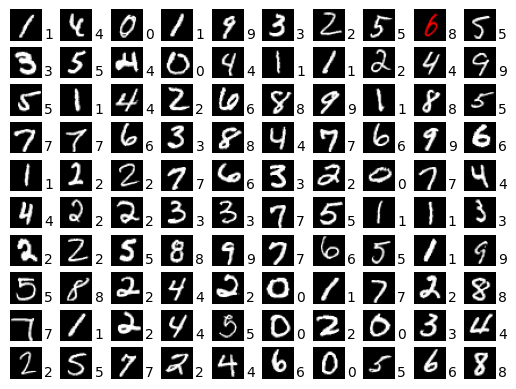

Epoch 5, log interval no.:0, Loss=0.0010
Epoch 5, log interval no.:1, Loss=0.0255
Epoch 5, log interval no.:2, Loss=0.0822
Epoch 5, log interval no.:3, Loss=0.0049
Epoch 5, log interval no.:4, Loss=0.0030
Epoch 5, log interval no.:5, Loss=0.0002
Epoch 5, log interval no.:6, Loss=0.0279
Epoch 5, log interval no.:7, Loss=0.0020
Epoch 5, log interval no.:8, Loss=0.0061
Epoch 5, log interval no.:9, Loss=0.0120

Test set: Average loss: 0.0775, Accuracy: 9814/10000 (98.14%)



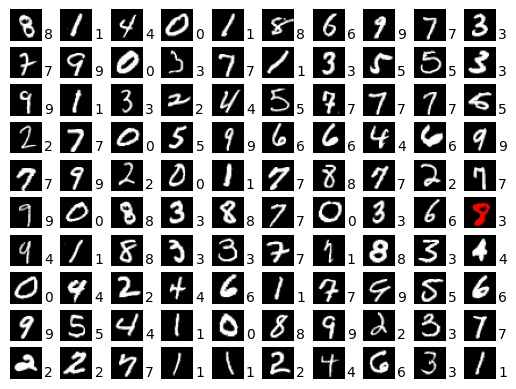

Epoch 6, log interval no.:0, Loss=0.0016
Epoch 6, log interval no.:1, Loss=0.0025
Epoch 6, log interval no.:2, Loss=0.0007
Epoch 6, log interval no.:3, Loss=0.0123
Epoch 6, log interval no.:4, Loss=0.0013
Epoch 6, log interval no.:5, Loss=0.0014
Epoch 6, log interval no.:6, Loss=0.0850
Epoch 6, log interval no.:7, Loss=0.0572
Epoch 6, log interval no.:8, Loss=0.0012
Epoch 6, log interval no.:9, Loss=0.0004

Test set: Average loss: 0.0739, Accuracy: 9831/10000 (98.31%)



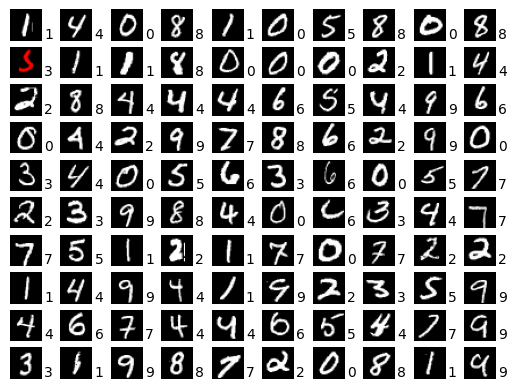

Epoch 7, log interval no.:0, Loss=0.0138
Epoch 7, log interval no.:1, Loss=0.0014
Epoch 7, log interval no.:2, Loss=0.0033
Epoch 7, log interval no.:3, Loss=0.0027
Epoch 7, log interval no.:4, Loss=0.0003
Epoch 7, log interval no.:5, Loss=0.0024
Epoch 7, log interval no.:6, Loss=0.0019
Epoch 7, log interval no.:7, Loss=0.0003
Epoch 7, log interval no.:8, Loss=0.0001
Epoch 7, log interval no.:9, Loss=0.0031

Test set: Average loss: 0.0785, Accuracy: 9827/10000 (98.27%)



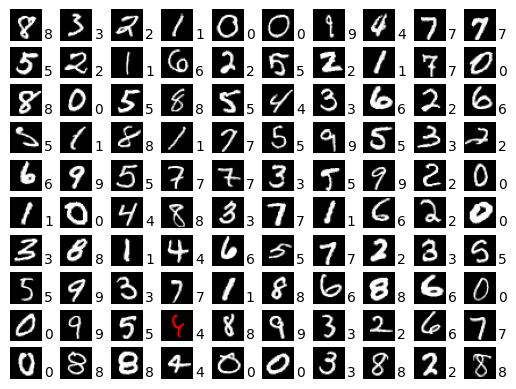

Epoch 8, log interval no.:0, Loss=0.0006
Epoch 8, log interval no.:1, Loss=0.0167
Epoch 8, log interval no.:2, Loss=0.0023
Epoch 8, log interval no.:3, Loss=0.0004
Epoch 8, log interval no.:4, Loss=0.0037
Epoch 8, log interval no.:5, Loss=0.0009
Epoch 8, log interval no.:6, Loss=0.0008
Epoch 8, log interval no.:7, Loss=0.0109
Epoch 8, log interval no.:8, Loss=0.0055
Epoch 8, log interval no.:9, Loss=0.0048

Test set: Average loss: 0.0841, Accuracy: 9826/10000 (98.26%)



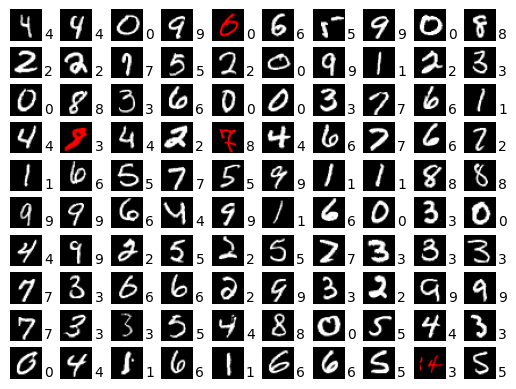

Epoch 9, log interval no.:0, Loss=0.0088
Epoch 9, log interval no.:1, Loss=0.0020
Epoch 9, log interval no.:2, Loss=0.0011
Epoch 9, log interval no.:3, Loss=0.0012
Epoch 9, log interval no.:4, Loss=0.0010
Epoch 9, log interval no.:5, Loss=0.0002
Epoch 9, log interval no.:6, Loss=0.0057
Epoch 9, log interval no.:7, Loss=0.0002
Epoch 9, log interval no.:8, Loss=0.0003
Epoch 9, log interval no.:9, Loss=0.0614

Test set: Average loss: 0.0837, Accuracy: 9823/10000 (98.23%)



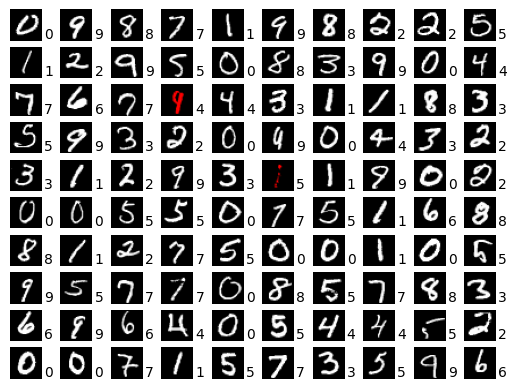

Epoch 10, log interval no.:0, Loss=0.0016
Epoch 10, log interval no.:1, Loss=0.0162
Epoch 10, log interval no.:2, Loss=0.0001
Epoch 10, log interval no.:3, Loss=0.0008
Epoch 10, log interval no.:4, Loss=0.0053
Epoch 10, log interval no.:5, Loss=0.0001
Epoch 10, log interval no.:6, Loss=0.0011
Epoch 10, log interval no.:7, Loss=0.0004
Epoch 10, log interval no.:8, Loss=0.0007
Epoch 10, log interval no.:9, Loss=0.0394

Test set: Average loss: 0.0843, Accuracy: 9825/10000 (98.25%)



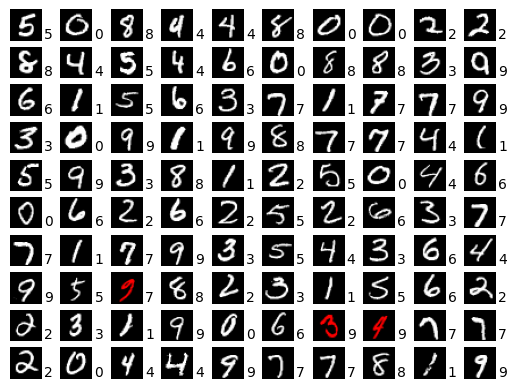

In [45]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpointFCNet2.pt")

Epoch 1, log interval no.:0, Loss=2.3437
Epoch 1, log interval no.:1, Loss=0.2909
Epoch 1, log interval no.:2, Loss=0.1062
Epoch 1, log interval no.:3, Loss=0.2030
Epoch 1, log interval no.:4, Loss=0.2678
Epoch 1, log interval no.:5, Loss=0.1552
Epoch 1, log interval no.:6, Loss=0.3011
Epoch 1, log interval no.:7, Loss=0.1408
Epoch 1, log interval no.:8, Loss=0.0772
Epoch 1, log interval no.:9, Loss=0.1973

Test set: Average loss: 0.1164, Accuracy: 9675/10000 (96.75%)



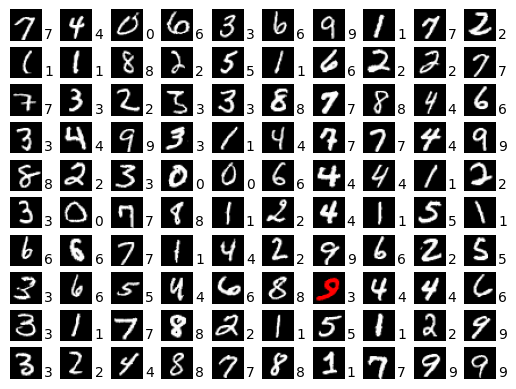

Epoch 2, log interval no.:0, Loss=0.0913
Epoch 2, log interval no.:1, Loss=0.0864
Epoch 2, log interval no.:2, Loss=0.1003
Epoch 2, log interval no.:3, Loss=0.0589
Epoch 2, log interval no.:4, Loss=0.0043
Epoch 2, log interval no.:5, Loss=0.2235
Epoch 2, log interval no.:6, Loss=0.0082
Epoch 2, log interval no.:7, Loss=0.2852
Epoch 2, log interval no.:8, Loss=0.1291
Epoch 2, log interval no.:9, Loss=0.0406

Test set: Average loss: 0.0728, Accuracy: 9772/10000 (97.72%)



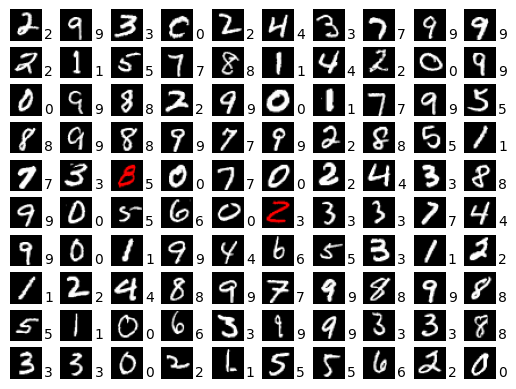

Epoch 3, log interval no.:0, Loss=0.1163
Epoch 3, log interval no.:1, Loss=0.1853
Epoch 3, log interval no.:2, Loss=0.1269
Epoch 3, log interval no.:3, Loss=0.0433
Epoch 3, log interval no.:4, Loss=0.0430
Epoch 3, log interval no.:5, Loss=0.0213
Epoch 3, log interval no.:6, Loss=0.0364
Epoch 3, log interval no.:7, Loss=0.0789
Epoch 3, log interval no.:8, Loss=0.0765
Epoch 3, log interval no.:9, Loss=0.0069

Test set: Average loss: 0.0633, Accuracy: 9806/10000 (98.06%)



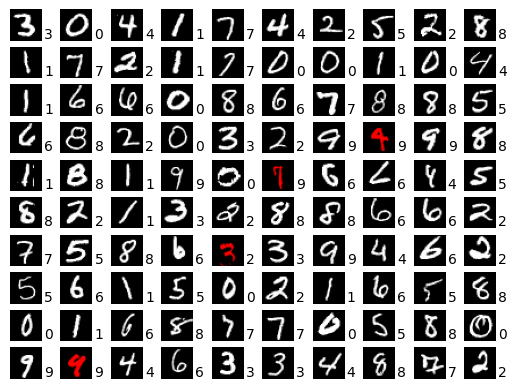

Epoch 4, log interval no.:0, Loss=0.0033
Epoch 4, log interval no.:1, Loss=0.0440
Epoch 4, log interval no.:2, Loss=0.1211
Epoch 4, log interval no.:3, Loss=0.0129
Epoch 4, log interval no.:4, Loss=0.0313
Epoch 4, log interval no.:5, Loss=0.1292
Epoch 4, log interval no.:6, Loss=0.2388
Epoch 4, log interval no.:7, Loss=0.0455
Epoch 4, log interval no.:8, Loss=0.0693
Epoch 4, log interval no.:9, Loss=0.0265

Test set: Average loss: 0.0594, Accuracy: 9827/10000 (98.27%)



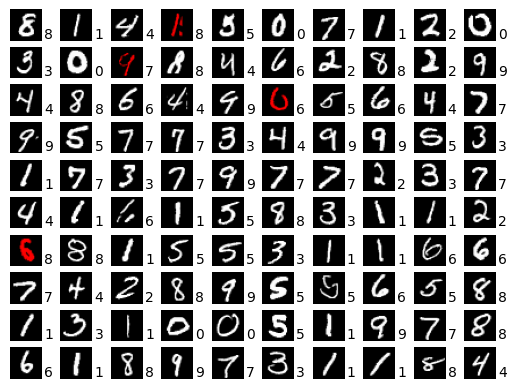

Epoch 5, log interval no.:0, Loss=0.0015
Epoch 5, log interval no.:1, Loss=0.0099
Epoch 5, log interval no.:2, Loss=0.0226
Epoch 5, log interval no.:3, Loss=0.0028
Epoch 5, log interval no.:4, Loss=0.0456
Epoch 5, log interval no.:5, Loss=0.0816
Epoch 5, log interval no.:6, Loss=0.0054
Epoch 5, log interval no.:7, Loss=0.0091
Epoch 5, log interval no.:8, Loss=0.0336
Epoch 5, log interval no.:9, Loss=0.0470

Test set: Average loss: 0.0544, Accuracy: 9833/10000 (98.33%)



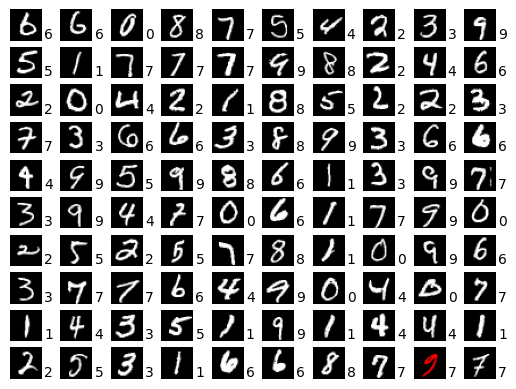

Epoch 6, log interval no.:0, Loss=0.0344
Epoch 6, log interval no.:1, Loss=0.0269
Epoch 6, log interval no.:2, Loss=0.0019
Epoch 6, log interval no.:3, Loss=0.0169
Epoch 6, log interval no.:4, Loss=0.0184
Epoch 6, log interval no.:5, Loss=0.0288
Epoch 6, log interval no.:6, Loss=0.0458
Epoch 6, log interval no.:7, Loss=0.1181
Epoch 6, log interval no.:8, Loss=0.0053
Epoch 6, log interval no.:9, Loss=0.0078

Test set: Average loss: 0.0522, Accuracy: 9852/10000 (98.52%)



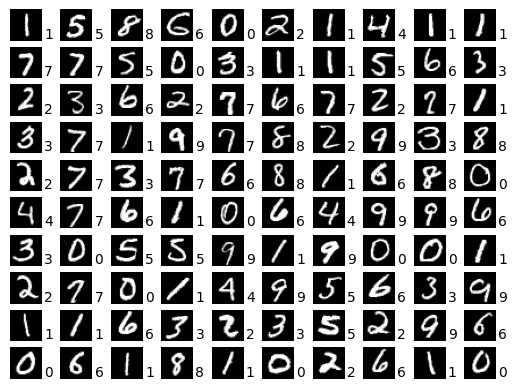

Epoch 7, log interval no.:0, Loss=0.0007
Epoch 7, log interval no.:1, Loss=0.0002
Epoch 7, log interval no.:2, Loss=0.0025
Epoch 7, log interval no.:3, Loss=0.0289
Epoch 7, log interval no.:4, Loss=0.0013
Epoch 7, log interval no.:5, Loss=0.0051
Epoch 7, log interval no.:6, Loss=0.0147
Epoch 7, log interval no.:7, Loss=0.0077
Epoch 7, log interval no.:8, Loss=0.0135
Epoch 7, log interval no.:9, Loss=0.0031

Test set: Average loss: 0.0530, Accuracy: 9843/10000 (98.43%)



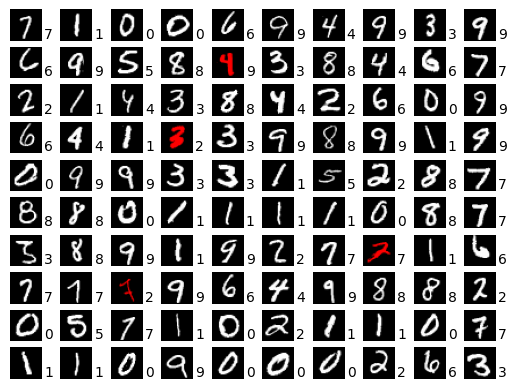

Epoch 8, log interval no.:0, Loss=0.0041
Epoch 8, log interval no.:1, Loss=0.0033
Epoch 8, log interval no.:2, Loss=0.0049
Epoch 8, log interval no.:3, Loss=0.0271
Epoch 8, log interval no.:4, Loss=0.0106
Epoch 8, log interval no.:5, Loss=0.0135
Epoch 8, log interval no.:6, Loss=0.0163
Epoch 8, log interval no.:7, Loss=0.0012
Epoch 8, log interval no.:8, Loss=0.0024
Epoch 8, log interval no.:9, Loss=0.0006

Test set: Average loss: 0.0541, Accuracy: 9845/10000 (98.45%)



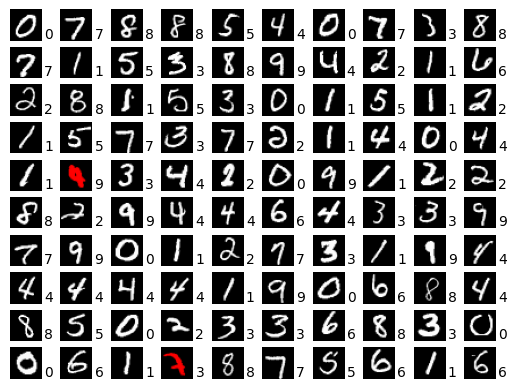

Epoch 9, log interval no.:0, Loss=0.0005
Epoch 9, log interval no.:1, Loss=0.1129
Epoch 9, log interval no.:2, Loss=0.0120
Epoch 9, log interval no.:3, Loss=0.0004
Epoch 9, log interval no.:4, Loss=0.0046
Epoch 9, log interval no.:5, Loss=0.0064
Epoch 9, log interval no.:6, Loss=0.0035
Epoch 9, log interval no.:7, Loss=0.0027
Epoch 9, log interval no.:8, Loss=0.0041
Epoch 9, log interval no.:9, Loss=0.0003

Test set: Average loss: 0.0540, Accuracy: 9848/10000 (98.48%)



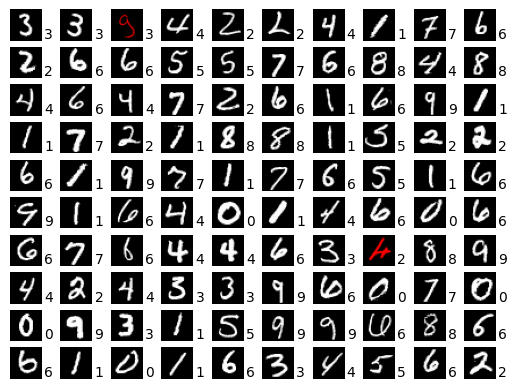

Epoch 10, log interval no.:0, Loss=0.0047
Epoch 10, log interval no.:1, Loss=0.0375
Epoch 10, log interval no.:2, Loss=0.0082
Epoch 10, log interval no.:3, Loss=0.0302
Epoch 10, log interval no.:4, Loss=0.0297
Epoch 10, log interval no.:5, Loss=0.0036
Epoch 10, log interval no.:6, Loss=0.0057
Epoch 10, log interval no.:7, Loss=0.0097
Epoch 10, log interval no.:8, Loss=0.0006
Epoch 10, log interval no.:9, Loss=0.0059

Test set: Average loss: 0.0536, Accuracy: 9850/10000 (98.50%)



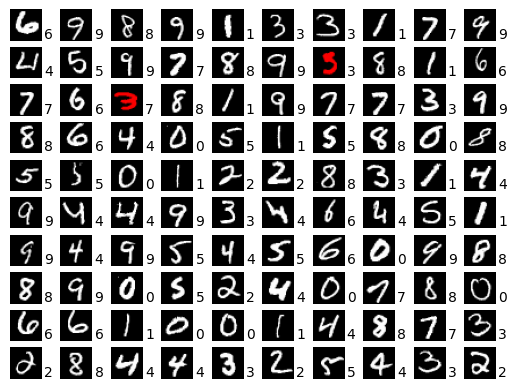

In [46]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpointFCNet3.pt")